# Breast Cancer dataset & feature selection process

This notebook shows some data selection and engineering processes that may be useful in real world applications.

To classify data, I will use both `SGDClassifier` and `RandomForestClassifier`, which is a very robust classifier and due to its ensemble nature, it is less prone to overfitting than other classifiers.

Because the dataset isn't that big, only 569 entries, here is used 10 fold cross validation.

**Feature selection methods:**
- chi2 test, top 5 most important features
- Pearson correlation test, top 5 most important features
- L1-regurarization-based feature elimination
- RFECV (recursive feature elimination with cross validation)
- Tree-based method (via `feature_importances_` attribute)
- SelectPercentile (50%) with F-test

Beside feature selection, optionally, there can be used some feature engineering methods, like polynomial features, normalization, and scaling.

**Imports**

In [13]:
from __future__ import print_function

from sklearn import (tree, feature_selection, datasets, cross_validation, ensemble,
                     preprocessing, linear_model)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

**Load dataset**

In [14]:
data = datasets.load_breast_cancer()
X = data.data
y = data.target
description = data.DESCR

print(description)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)
        
        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.
 

**[OPTIONAL] Scaling**

In [8]:
use_scaling = False

X_scaled = preprocessing.scale(X)

if use_scaling == True and X.all() != X_scaled.all():
    X = X_scaled
    print("WARNING!!! X was scaled.")

**[OPTIONAL] Normalization**

In [9]:
use_normalization = False

X_normalized = preprocessing.normalize(X)

if use_normalization == True:
    X = X_normalized
    print("WARNING!!! X was normalized.")

**[OPTIONAL] Polynomial features**

In [10]:
use_poly_features = False

X_extended = preprocessing.PolynomialFeatures().fit_transform(X)

if use_poly_features == True and X.all() != X_extended.all():
    X = X_extended
    print("New shape:", X_extended.shape)
    print("WARNING!!! X was extended with polynomial features.")

**Data variance**

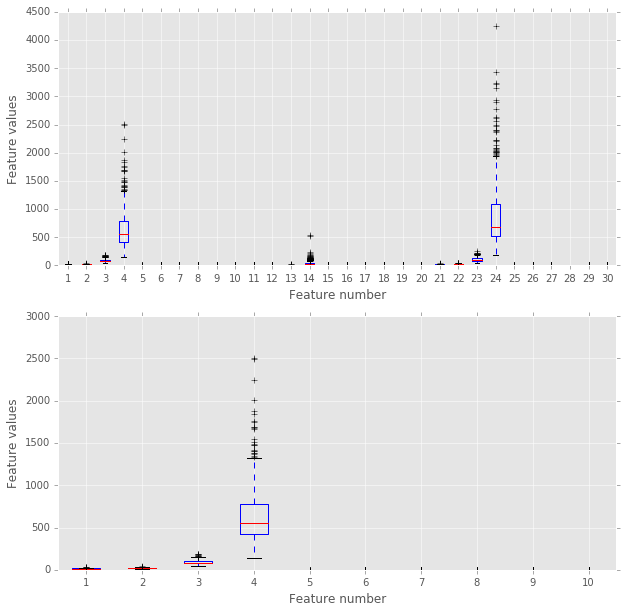

In [15]:
plt.figure(figsize=(10, 10), dpi=10)
plt.subplot(211)
plt.boxplot(X)
plt.xlabel("Feature number")
plt.ylabel("Feature values")

plt.subplot(212)
plt.boxplot(X[:, :10])
plt.xlabel("Feature number")
plt.ylabel("Feature values")

plt.show()

**Correlation test**

Using `chi2` function we are now able to compute the correlation of each feature with the class label.
It means that we can choose specific features that contribute the most to determination wherever a feature vector coresponds to one class or another.

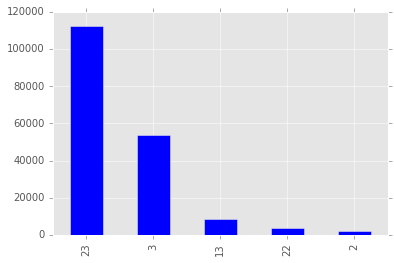

In [16]:
chi_sq = feature_selection.chi2(X, y)
corr_table = pd.DataFrame(zip(*chi_sq), columns = ("Correlation", "P-value"))

top_features = corr_table.sort_values("Correlation", ascending=False).head()

_ = top_features["Correlation"].plot.bar()

**Pearson correlation matrix based feature selection**

In [17]:
labels = ["radius", "texture", "perimeter", "area", "smoothness", "compactness",
          "concavity", "concave points", "symmetry", "fractal dimension"]

all_labels = map(lambda x: x + " avg", labels) + \
             map(lambda x: x + " stderr", labels) + \
             map(lambda x: x + " max", labels)

df = pd.DataFrame(X)
df1 = pd.DataFrame(X[:, :10], columns=labels)
df2 = pd.DataFrame(X[:, 10:20])
df3 = pd.DataFrame(X[:, 20:])
pearson = pd.concat([df, pd.DataFrame(y, columns=["prediction"])], axis=1).corr()
indices = pearson[abs(pearson["prediction"]) > 0.55]
indices

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,prediction
0,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,-0.730029
2,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,-0.742636
3,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,-0.708984
5,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,-0.596534
6,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,-0.696360
7,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,-0.776614
10,0.679090,0.275869,0.691765,0.732562,0.301467,0.497473,0.631925,0.698050,0.303379,0.000111,...,0.194799,0.719684,0.751548,0.141919,0.287103,0.380585,0.531062,0.094543,0.049559,-0.567134
12,0.674172,0.281673,0.693135,0.726628,0.296092,0.548905,0.660391,0.710650,0.313893,0.039830,...,0.200371,0.721031,0.730713,0.130054,0.341919,0.418899,0.554897,0.109930,0.085433,-0.556141
20,0.969539,0.352573,0.969476,0.962746,0.213120,0.535315,0.688236,0.830318,0.185728,-0.253691,...,0.359921,0.993708,0.984015,0.216574,0.475820,0.573975,0.787424,0.243529,0.093492,-0.776454
22,0.965137,0.358040,0.970387,0.959120,0.238853,0.590210,0.729565,0.855923,0.219169,-0.205151,...,0.365098,1.000000,0.977578,0.236775,0.529408,0.618344,0.816322,0.269493,0.138957,-0.782914


**Visualize correlations between features**

Special thantks to *[Zapf Consulting](github.com/Zapf-Consulting/solar-correlation-map)* for their solar correlation visualization tool.

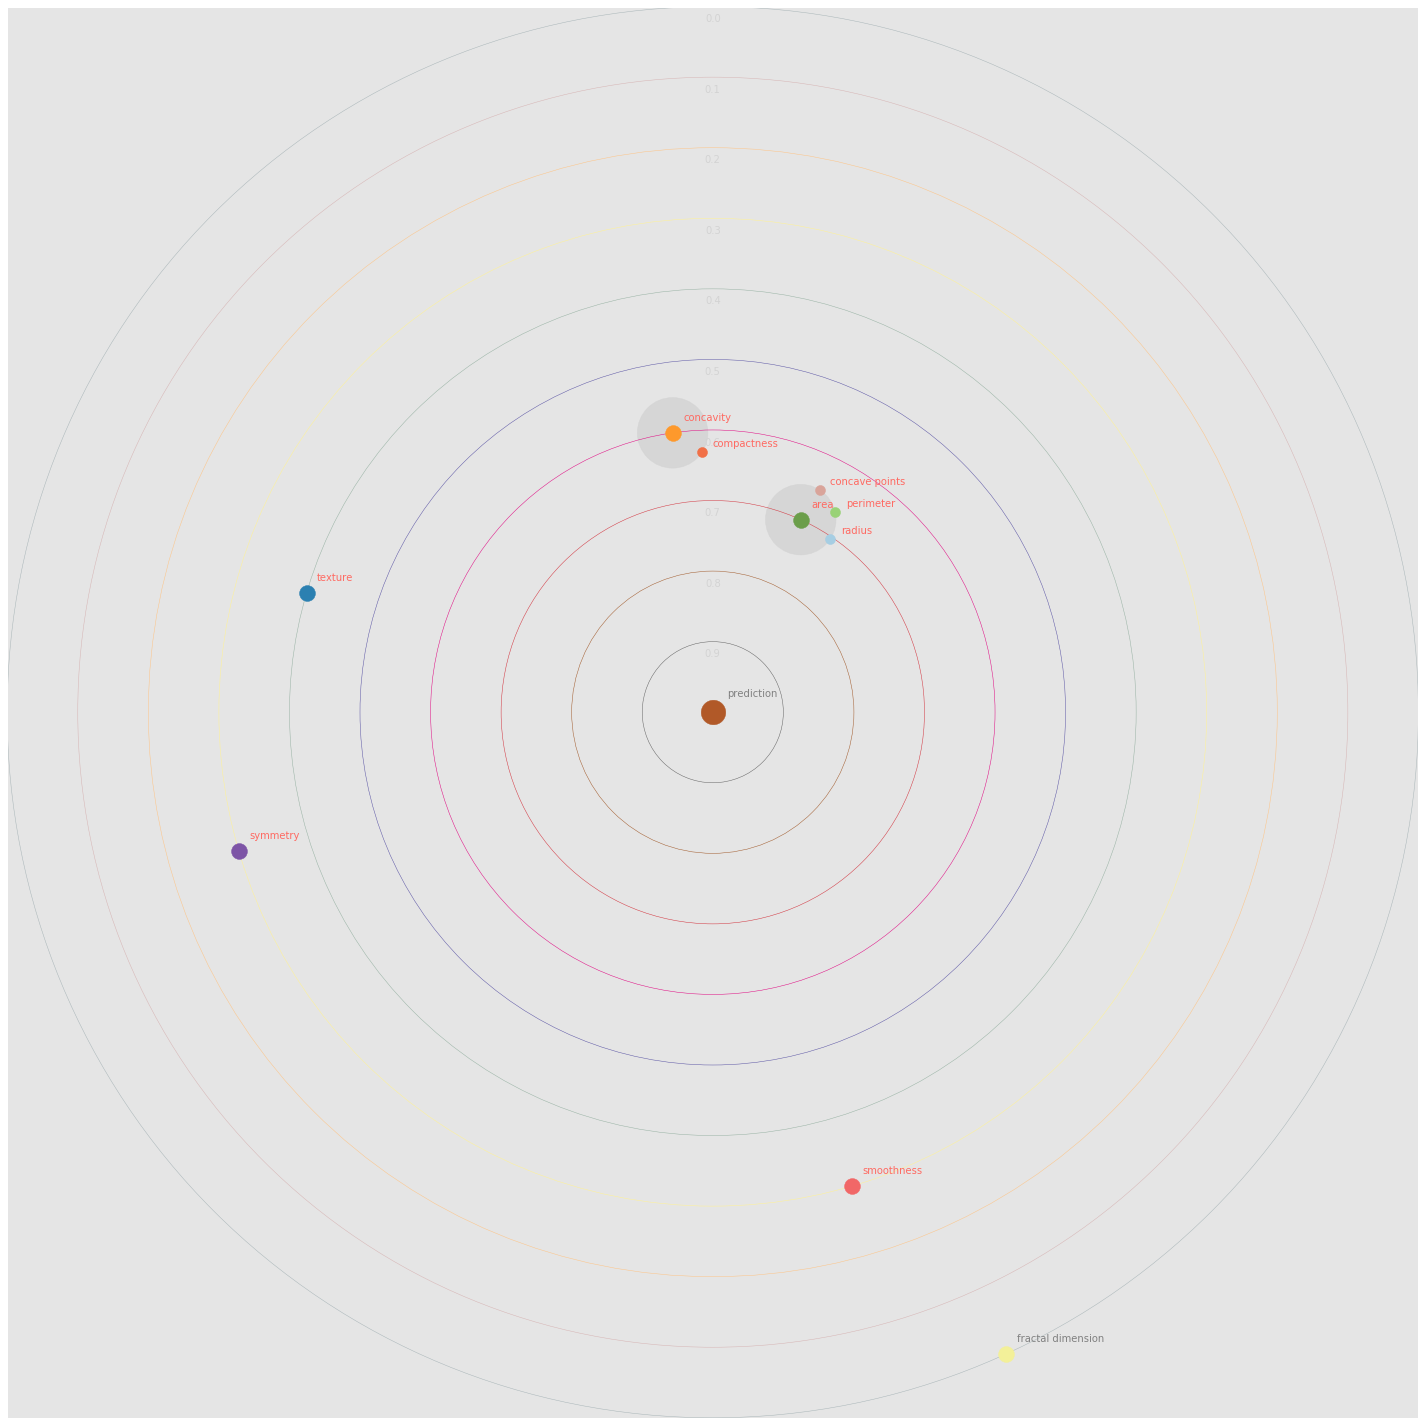

In [18]:
from solar_correlation_map.solar_corr import solar_corr

labels_full = labels + ["prediction"]


with open("temp.csv", "w") as fp:
    fp.writelines("id" + pd.concat([df1, pd.DataFrame(y)], axis=1).to_csv())

data = np.genfromtxt("temp.csv", delimiter=",", skip_header=1)[:, 1:]

solar_corr(data, labels=labels_full, center="prediction", save_png=False)

!rm temp.csv

**10 fold Cross Validation**

In [19]:
kfcv = cross_validation.KFold(len(y), n_folds = 10, shuffle = True)

**Model (Random Forest Model or Logistic regression)**

In [20]:
kind = "logistic"
# kind = "forest"

model = {
    "forest": ensemble.RandomForestClassifier(),
    "logistic": linear_model.SGDClassifier(n_iter=1000, n_jobs=3)
}[kind]

**Vanila Model**

No feature selection technique applied.

In [21]:
scores = [model.fit(X[train], y[train]).score(X[test], y[test]) for train, test in kfcv]

rows, cols = X.shape
print("Feature vector size: {0} elements.".format(cols))
print("Accuracy of vanila model: {0}".format(sum(scores) / kfcv.n_folds))

Feature vector size: 30 elements.
Accuracy of vanila model: 0.880701754386


**Model + Pearson correlation test**

See previous big matrix.

In [22]:
unique_features = indices.index.get_values()[:-1].tolist()

X_pearson = X[:, unique_features]

scores = [model.fit(X_pearson[train], y[train]).score(X_pearson[test], y[test]) for train, test in kfcv]

rows, cols = X_pearson.shape

print("Scaling:", use_scaling)
print("Normalization:", use_normalization)
print("Polynomial Features:", use_poly_features)

print("Feature vector size: {0} elements.".format(cols))
print("Accuracy of 'pearson' model: {0}".format(sum(scores) / kfcv.n_folds))

Scaling: False
Normalization: False
Polynomial Features: False
Feature vector size: 14 elements.
Accuracy of 'pearson' model: 0.889473684211


**Model + L1 regulazier feature selection**

In [24]:
clf = linear_model.LassoCV()

sfm = feature_selection.SelectFromModel(clf, threshold=0.002)
sfm.fit(X, y)

X_l1 = sfm.transform(X)

scores = [model.fit(X_l1[train], y[train]).score(X_l1[test], y[test]) for train, test in kfcv]

rows, cols = X_l1.shape

print("Scaling:", use_scaling)
print("Normalization:", use_normalization)
print("Polynomial Features:", use_poly_features)

print("Feature vector size: {0} elements.".format(cols))
print("Accuracy of 'L1' model: {0}".format(sum(scores) / kfcv.n_folds))

Scaling: False
Normalization: False
Polynomial Features: False
Feature vector size: 2 elements.
Accuracy of 'L1' model: 0.928007518797


**Model + chi squared correlation test**

After choosing 5 most important features we got a 6 fold reduction in size, keeping the most informative features.

In [25]:
indices = top_features.to_dense().index.get_values()

X_reduced = X[:, indices]

scores = [model.fit(X_reduced[train], y[train]).score(X_reduced[test], y[test]) for train, test in kfcv]

rows, cols = X_reduced.shape

print("Scaling:", use_scaling)
print("Normalization:", use_normalization)
print("Polynomial Features:", use_poly_features)

print("Feature vector size: {0} elements.".format(cols))
print("Accuracy of chi2 model: {0}".format(sum(scores) / kfcv.n_folds))

Scaling: False
Normalization: False
Polynomial Features: False
Feature vector size: 5 elements.
Accuracy of chi2 model: 0.910494987469


**Model + Recursive Feature Elimination (RFE)**

In [26]:
_sgd = linear_model.SGDClassifier(n_iter = 100)
rfecv = feature_selection.RFECV(_sgd, cv = 10, scoring = "accuracy")

rfecv.fit(X, y)

X_new = rfecv.transform(X)

scores = [model.fit(X_new[train], y[train]).score(X_new[test], y[test]) for train, test in kfcv]

rows, cols = X_new.shape

print("Scaling:", use_scaling)
print("Normalization:", use_normalization)
print("Polynomial Features:", use_poly_features)

print("Feature vector size: {0} elements.".format(cols))
print("Accuracy of RFE model: {0}".format(sum(scores) / kfcv.n_folds))

Scaling: False
Normalization: False
Polynomial Features: False
Feature vector size: 23 elements.
Accuracy of RFE model: 0.910526315789


**Model + Tree Feature Selection**

In [27]:
feature_importance_tree = tree.DecisionTreeClassifier()
feature_importance_tree.fit(X, y)

feature_importance_list = feature_importance_tree.feature_importances_.tolist()
indices = zip(*sorted(enumerate(feature_importance_list), key=lambda x: x[1], reverse=True)[:5])[0]

X_tree = X[:, indices]

scores = [model.fit(X_tree[train], y[train]).score(X_tree[test], y[test]) for train, test in kfcv]

rows, cols = X_tree.shape

print("Scaling:", use_scaling)
print("Normalization:", use_normalization)
print("Polynomial Features:", use_poly_features)

print("Feature vector size: {0} elements.".format(cols))
print("Accuracy of tree-based model: {0}".format(sum(scores) / kfcv.n_folds))

Scaling: False
Normalization: False
Polynomial Features: False
Feature vector size: 5 elements.
Accuracy of tree-based model: 0.936748120301


**Model + SelectPercentile (F-test)**

In [28]:
selector = feature_selection.SelectPercentile(percentile=50)

X_selected = selector.fit_transform(X, y)

scores = [model.fit(X_selected[train], y[train]).score(X_selected[test], y[test]) for train, test in kfcv]

rows, cols = X_selected.shape

print("Scaling:", use_scaling)
print("Normalization:", use_normalization)
print("Polynomial Features:", use_poly_features)

print("Feature vector size: {0} elements.".format(cols))
print("Accuracy of F-test model: {0}".format(sum(scores) / kfcv.n_folds))

Scaling: False
Normalization: False
Polynomial Features: False
Feature vector size: 15 elements.
Accuracy of F-test model: 0.903477443609


# Conclusion

As usual, feature scaling/normalization is very important. After numerous experiments, it can be said that it is maybe the most important preprocessing stage. <br/>
The most stable feature selection method seems to be the tree based one. The resulting accuracy is high (~0.97) for the linear model and what is more important, is relatively stable. Also, it is one of the fastest methods.

It is strange but accuracy for ensemble model remains almost unchanged after any feature selection method. The reason may be the specific of tree-based algorithms to select the most important features out-of-the-box. Moreover, ensemble methods are much less prone to overfitting.